<a href="https://colab.research.google.com/github/SonuDash/test_codes/blob/main/mobilenet_cats_vs_dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers


In [3]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [4]:
CLASSIFIER_URL ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential([
    hub.KerasLayer(CLASSIFIER_URL, input_shape=(IMAGE_RES, IMAGE_RES, 3))
])

73728/61306 [====================================] - 0s 0us/step


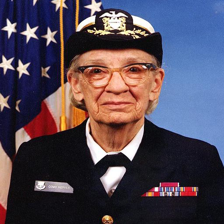

In [5]:
import numpy as np
import PIL.Image as Image

grace_hopper = tf.keras.utils.get_file('image.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper

In [6]:
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

(1, 1001)

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class

653

24576/10484 [======================================================================] - 0s 0us/step


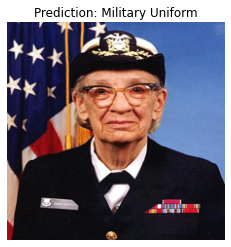

In [9]:
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

plt.imshow(grace_hopper)
plt.axis('off')
predicted_class_name = imagenet_labels[predicted_class]
_=plt.title("Prediction: "+predicted_class_name.title())

In [10]:
setattr(tfds.image_classification.cats_vs_dogs, '_URL',"https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip")

(train_examples, validation_examples), info = tfds.load(
    'cats_vs_dogs',
    with_info=True,
    as_supervised=True,
    split=['train[:80%]', 'train[80%:]'],
)

num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incompleteN8Z4D9/cats_vs_dogs-train.tfrecord


  0%|          | 0/23262 [00:00<?, ? examples/s]

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [11]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (262, 350, 3)
Image 2 shape: (409, 336, 3)
Image 3 shape: (493, 500, 3)


In [12]:
def format_image(image, label):
  image=tf.image.resize(image,(IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)


In [13]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]
predicted_class_names

array(['kelpie', 'boxer', 'kit fox', 'black-and-tan coonhound', 'tabby',
       'lynx', 'kelpie', 'Persian cat', 'toy terrier', 'Great Dane',
       'Weimaraner', 'tabby', 'kelpie', 'Persian cat', 'toy terrier',
       'Egyptian cat', 'Egyptian cat', 'Irish wolfhound', 'affenpinscher',
       'tabby', 'tabby', 'computer keyboard', 'tabby', 'tabby',
       'toy poodle', 'kelpie', 'redbone', 'Labrador retriever',
       'tiger cat', 'tabby', 'American Staffordshire terrier', 'tabby'],
      dtype='<U30')

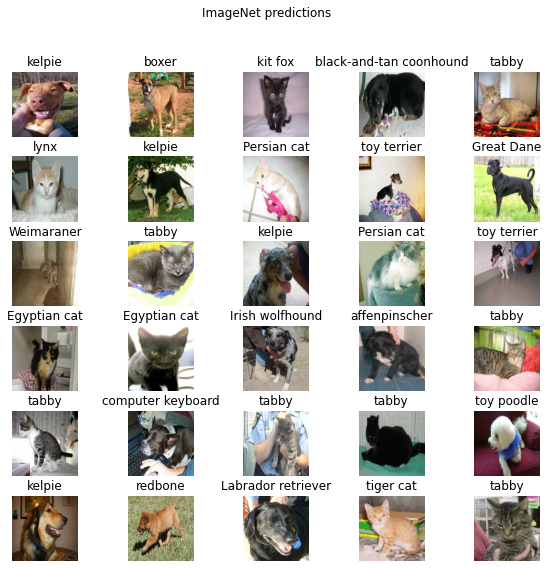

In [14]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_=plt.suptitle("ImageNet predictions")

In [15]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [18]:
feature_batch = feature_extractor(image_batch)
print(feature_batch.shape)

(32, 1280)


In [19]:
feature_extractor.trainable = False

In [20]:
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(2)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 2)                 2562      
                                                                 
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________


In [21]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

EPOCHS = 6
history = model.fit(train_batches,
                    epochs = EPOCHS,
                    validation_data=validation_batches)

Epoch 1/6
582/582 [==============================] - 716s 1s/step - loss: 0.0525 - accuracy: 0.9836 - val_loss: 0.0330 - val_accuracy: 0.9888
Epoch 2/6
582/582 [==============================] - 618s 1s/step - loss: 0.0301 - accuracy: 0.9901 - val_loss: 0.0306 - val_accuracy: 0.9895
Epoch 3/6
582/582 [==============================] - 620s 1s/step - loss: 0.0252 - accuracy: 0.9915 - val_loss: 0.0363 - val_accuracy: 0.9882
Epoch 4/6
582/582 [==============================] - 636s 1s/step - loss: 0.0222 - accuracy: 0.9924 - val_loss: 0.0327 - val_accuracy: 0.9899
Epoch 5/6
582/582 [==============================] - 626s 1s/step - loss: 0.0198 - accuracy: 0.9929 - val_loss: 0.0316 - val_accuracy: 0.9899
Epoch 6/6
582/582 [==============================] - 638s 1s/step - loss: 0.0167 - accuracy: 0.9946 - val_loss: 0.0312 - val_accuracy: 0.9905


Text(0.5, 1.0, 'Training and Validation Loss')

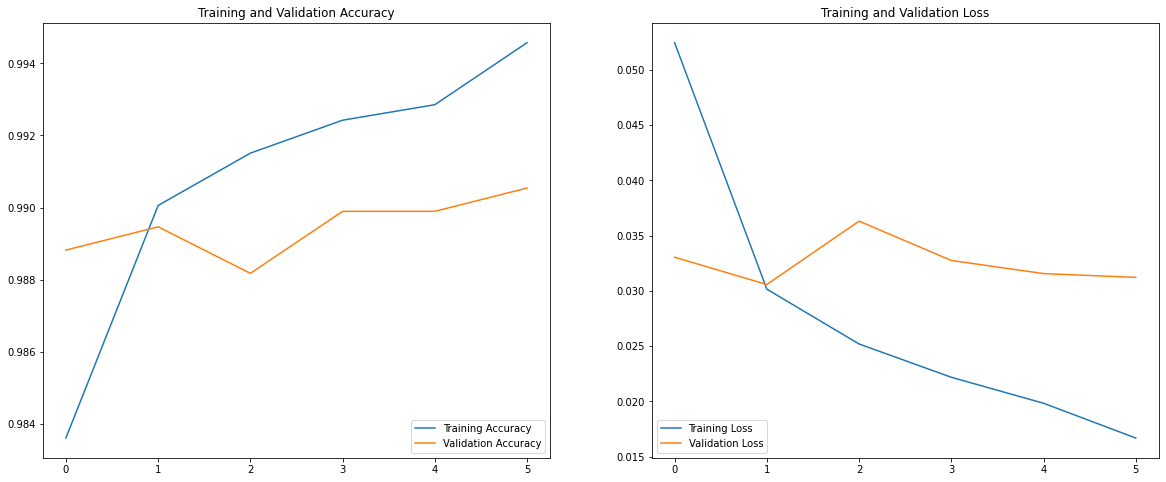

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(20,8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Training and Validation Loss')